# TFY41xx Fysikk våren 2021.

Programmet tar utgangspunkt i høyyden til de 8 festepunktene.
Deretter beregnes baneformen $y(x)$ ved hjelp av 7 tredjegradspolynomer, 
et for hvert intervall mellom to festepunkter, slik at både banen $y$, 
dens stigningstall $y^\prime = \frac{dy}{dx}$ og dens andrederiverte
 $y^{\prime \prime} = \frac{d^2y}{dx^2}$ er kontinuerlige i de 6 indre festepunktene.
 I tillegg velges null krumning (andrederivert) 
 i banens to ytterste festepunkter (med `bc_type='natural'` nedenfor).
 Dette gir i alt 28 ligninger som fastlegger de 28 koeffisientene
 i de i alt 7 tredjegradspolynomene.

 De ulike banene er satt opp med tanke paa at kula skal 

*   Fullføre hele banen selv om den taper noe mekanisk energi underveis;
*   Rulle rent, uten  gli ("slure").


Vi importerer noedvendige biblioteker:

In [116]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline
from scipy import stats

newparams = {'figure.figsize': (12, 6), 'axes.labelsize': 20, 'xtick.labelsize': 16,
               'ytick.labelsize':16}
plt.rcParams.update(newparams)

Horisontal avstand mellom festepunktene er 0.200 m:

In [117]:
h = 0.200
xfast=np.asarray([0,h,2*h,3*h,4*h,5*h,6*h,7*h])

Start, slutt og steglengde i x-rettning

In [118]:
xmin = 0.000
xmax = 1.401
dx = 0.001

Skriv inn y-verdiene til banens 8 festepunkter i tabellen yfast, basert på avlesing i tracker.

In [119]:
# Import data
yfast = np.genfromtxt('C:\\Users\\erlendoien\\local_projects\\TFY4125\\lab\\data\\y_track.txt')
print(yfast)



[0.39656559 0.30088911 0.3043925  0.34308826 0.31593441 0.24291108
 0.24638069 0.26929356]


Programmet beregner deretter de 7 tredjegradspolynomene, et for hvert intervall mellom to nabofestepunkter. Med scipy.interpolate-funksjonen CubicSpline:

In [120]:
cs = CubicSpline(xfast, yfast, bc_type='natural')
x = np.arange(xmin, xmax, dx) 

Funksjonen arange returnerer verdier på det "halvåpne" intervallet
`[xmin,xmax)`, dvs slik at xmin er med mens xmax ikke er med. Her blir
dermed `x[0]=xmin=0.000`, `x[1]=xmin+1*dx=0.001`, ..., `x[1400]=xmax-dx=1.400`, 
dvs x blir en tabell med 1401 elementer

In [121]:
Nx = len(x)
y = cs(x)       #y=tabell med 1401 verdier for y(x)
dy = cs(x,1)    #dy=tabell med 1401 verdier for y'(x)
d2y = cs(x,2)   #d2y=tabell med 1401 verdier for y''(x)


Eksempel: Plotter banens form y(x):

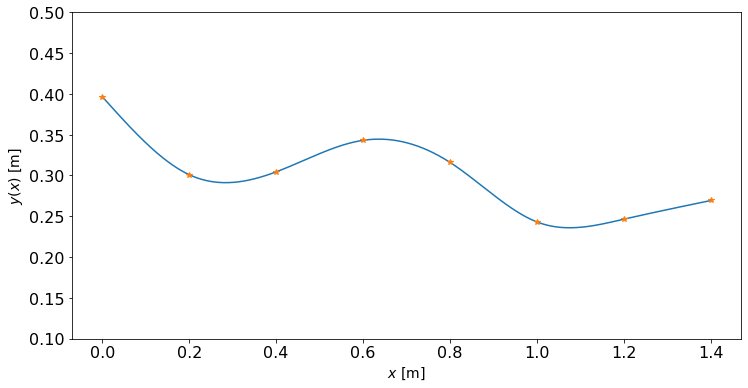

In [122]:
plt.plot(x,y,xfast,yfast,'*')
plt.xlabel(r'$x$ [m]', fontsize=14)
plt.grid(b=None)
plt.ylabel(r'$y(x)$ [m]', fontsize=14)
plt.ylim(0.10,0.5)
plt.grid()
plt.show()

## Implementerte funksjoner fra teorien

In [123]:
def v(y_val, y_0, c=2 / 5, g=9.81):
    """Kalkulerer hastigheten som funksjon av y"""
    return np.sqrt(2 * g * (y_0 - y_val) / (1 + c))

def k(y_val, y_arr, dy_arr, d2y_arr):
    """Kalkulerer krummingen for en gitt y"""
    y_index = np.where(y_val == y_arr)
    return d2y_arr[y_index] / (1 + dy_arr[y_index] ** 2) ** (3 / 2)

def a_rad(y_val, y_0, y_arr, dy_arr, d2y_arr):
    """Beregner sentripetalakselerasjonen for en gitt y"""
    return v(y_val, y_0=y_0) ** 2 * k(y_val, y_arr, dy_arr, d2y_arr)

def beta(y_val, y_arr, dy_arr):
    """Beregner vinkelen mellom loddlinjen og planet"""
    y_index = np.where(y_val == y_arr)
    return np.arctan(dy_arr[y_index])

def a(y_val, y_arr, dy_arr, c=2 / 5, g=9.81):
    return -g * np.sin(beta(y_val, y_arr, dy_arr)) / (1 + c)

def f(y_val, y_arr, dy_arr, c=2 / 5, g=9.81, M=0.031):
    """Beregner den statiske friksjonskraften for en gitt y"""
    _beta = beta(y_val, y_arr, dy_arr)
    return c * M * g * np.sin(_beta) / (1 + c)

def N(y_val, y_0, y_arr, dy_arr, d2y_arr, M=0.031, g=9.81):
    """Beregner normalkraften på kulen for en gitt y"""
    return M * (g * np.cos(beta(y_val, y_arr, dy_arr)) + a_rad(y_val, y_0, y_arr, dy_arr, d2y_arr))


### Formler for tidsutvikling

In [124]:
def v_x_n(y_val, y_0, y_arr, dy_arr):
    """x-komponent av hastigheten for en gitt punkt definert av y-verdi"""
    return v(y_val, y_0) * np.cos(beta(y_val, y_arr, dy_arr))

def t_n(n, y_0, y_arr, dy_arr, delta_x_n=dx):
    """Tidspunktet for punkt n"""
    if n == 0:
        return 0
    return 2 * delta_x_n / ( v_x_n(y[n], y_0, y_arr, dy_arr)[0] + v_x_n(y[n-1], y_0, y_arr, dy_arr)[0])

t = np.cumsum([t_n(n, y[0], y, dy) for n in np.arange(0, len(y))])

### Numeriske verdier

In [125]:
# Konstanter også for eksperimentelle verdier
M = 0.031
g = 9.81

In [160]:
# Helningsvinkel for hvert punkt
beta_deg = beta(y, y, dy)*180/np.pi

# Invers krumningsradius 
k_num = k(y, y, dy, d2y)

# Hastighet for hvert punkt
v_num = v(y, y[0])

# Normalkraft
N_num = N(y, y[0], y, dy, d2y)

# Forholdet mellom normal- og gravitasjonskraft
N_mg = N_num / (M*g)

# Friksjonskonstanten
f_N = np.abs(f(y, y, dy) / N_num)

## Tidsutviklingsgrafer

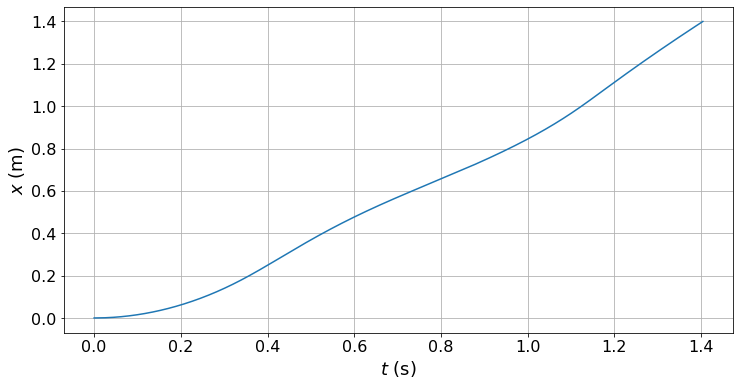

In [127]:
# Plot x(t)
plt.figure('x(t)',figsize=(12,6))
plt.plot(t, x)
plt.ylabel(r'$x$ (m)', fontsize=18)
plt.xlabel(r'$t$ (s)', fontsize=18)
plt.grid()
plt.show()

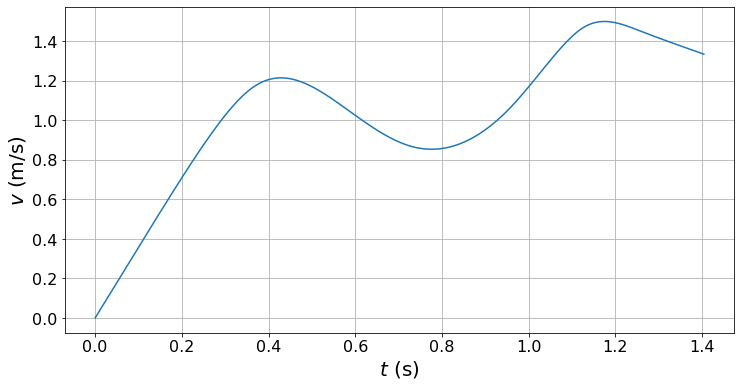

In [128]:
# Plot v(tid)
plt.figure('v(t)',figsize=(12,6))
plt.plot(t, v(y, y[0]))
plt.ylabel(r'$v$ (m/s)', fontsize=20)
plt.xlabel(r'$t$ (s)', fontsize=20)
plt.grid()
plt.show()

## Eksperimentelle data og verdier

In [129]:
import os
import pathlib

def get_data():
    data_lists = []
    data_path = pathlib.Path(os.getcwd()) / "data"
    for i in range(1,11):
        temp_data = np.genfromtxt(pathlib.Path(data_path).joinpath(f'{i}_txy.txt'))
        data_lists.append(temp_data)
    t_lists = [data_lists[i][:,0] for i in range(len(data_lists))] 
    x_lists = [data_lists[i][:,1] for i in range(len(data_lists))] 
    y_lists = [data_lists[i][:,2] for i in range(len(data_lists))]
    return t_lists, x_lists, y_lists

In [130]:
# Eksperimentell data - Representativt forsøk valgt
t_lists, x_lists, y_lists = get_data()

attempt = 7
t_exp, x_exp, y_exp = t_lists[attempt], x_lists[attempt], y_lists[attempt]
y_exp_0 = y_exp[0]

#### Beregner eksperimentelle $\frac{dy}{dx}$ og $\frac{d^2 y}{dx^2}$

In [131]:
# Beregner differanser
dy_exp = np.gradient(y_exp, x_exp)
d2y_exp = np.gradient(dy_exp, x_exp)

### Eksperimentelle verdier for representativt forsøk

In [132]:
# Helningsvinkler
beta_exp = beta(y_exp, y_exp, dy_exp)*180/np.pi

# Invers krumningsradius
k_exp = k(y_exp, y_exp, dy_exp, d2y_exp)

# Eksperimentell hastighet
v_exp = v(y_exp, y_exp_0)

# Normalkraft og forholdet til gravitasjonskraften
N_experimental = N(y_exp, y_exp[0], y_exp, dy_exp, d2y_exp)
N_mg_experimental = N_experimental / (M * g)

# Friksjonskonstanten
f_N_experimental = np.abs(f(y_exp, y_exp, dy_exp) / N_experimental)

## Grafer for samtlige forsøk

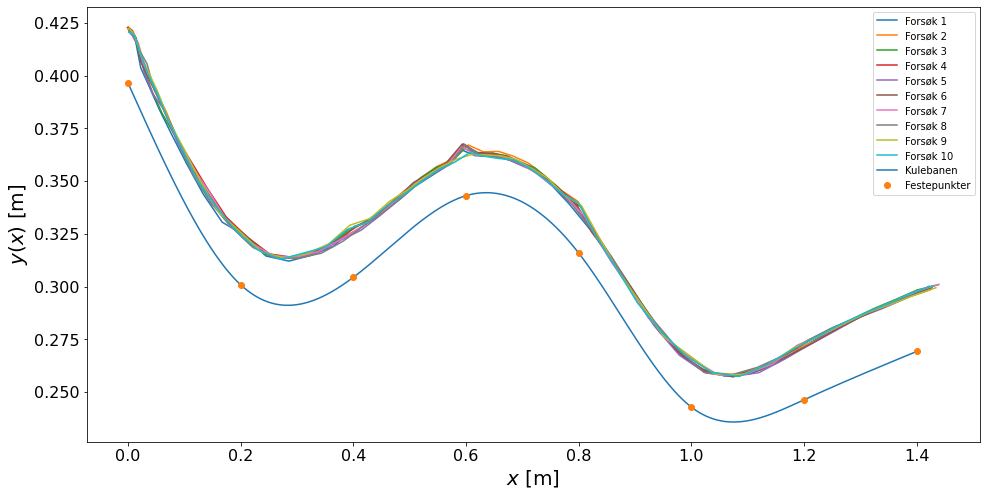

In [133]:
plt.figure('test',figsize=(16,8))
for index in range(len(x_lists)):
    plt.plot(x_lists[index], y_lists[index], label=f"Forsøk {index+1}")
plt.plot(x,y, label="Kulebanen")
plt.plot(xfast, yfast, 'o', label="Festepunkter")
plt.xlabel(r'$x$ [m]')
plt.ylabel(r'$y(x)$ [m]')
plt.legend()
plt.show()

<ipython-input-123-f0494489adb4>:3: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(2 * g * (y_0 - y_val) / (1 + c))
<ipython-input-123-f0494489adb4>:3: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(2 * g * (y_0 - y_val) / (1 + c))
<ipython-input-123-f0494489adb4>:3: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(2 * g * (y_0 - y_val) / (1 + c))
<ipython-input-123-f0494489adb4>:3: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(2 * g * (y_0 - y_val) / (1 + c))
<ipython-input-123-f0494489adb4>:3: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(2 * g * (y_0 - y_val) / (1 + c))
<ipython-input-123-f0494489adb4>:3: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(2 * g * (y_0 - y_val) / (1 + c))


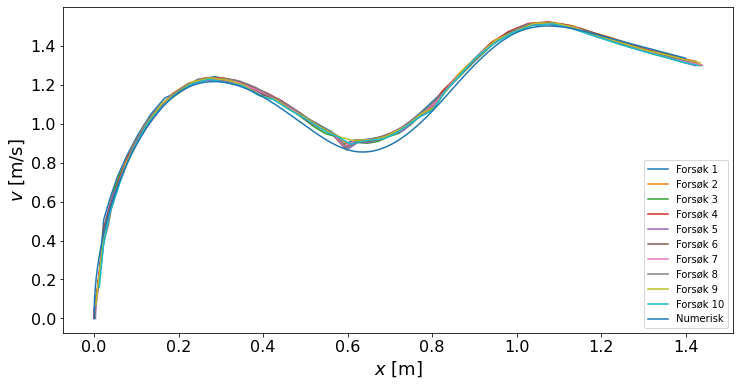

In [134]:
for index in range(len(x_lists)):
    plt.plot(x_lists[index], v(y_lists[index], y_lists[index][0]), label=f"Forsøk {index+1}")
plt.plot(x, v(y, y[0]), label="Numerisk")
#plt.plot(xfast, yfast, 'o', label="Festepunkter")
plt.xlabel(r'$x$ [m]', fontsize=18)
plt.ylabel(r'$v$ [m/s]', fontsize=18)
plt.legend()
plt.show()

# Sammenligning numerisk vs eksperimentell

In [148]:
def plot_comparison(x_num, y_num, x2, y2, ylabel, 
                    xlabel=r"$x$ [m]", num_label="Numerisk", exp_label="Forsøk 7",
                    save=False, file_name=None):
    fig = plt.figure()
    plt.plot(x_num,y_num, label=num_label)
    plt.plot(x2, y2, label=exp_label)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.legend(fontsize=18)
    if(save):
        plt.savefig(file_name, bbox_inches="tight")
    plt.show()

## Kulebane vs faktisk bane

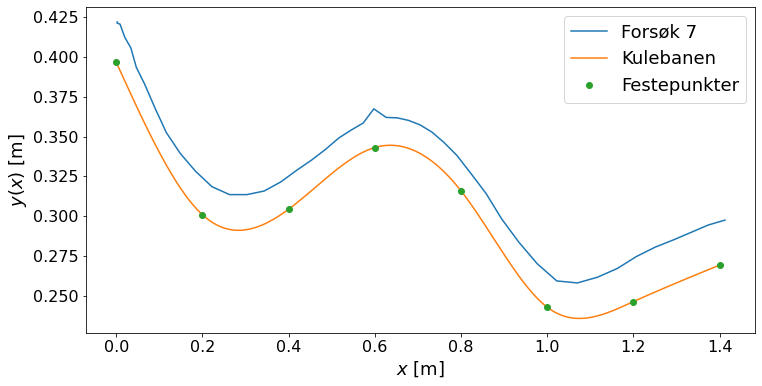

In [149]:
plt.plot(x_exp, y_exp, label="Forsøk 7")
plt.plot(x,y, label="Kulebanen")
plt.plot(xfast, yfast, 'o', label="Festepunkter")
plt.xlabel(r"$x$ [m]", fontsize=18)
plt.ylabel(r"$y(x)$ [m]", fontsize=18)
plt.legend(fontsize=18)
#plt.savefig("y_x_plot.pdf", bbox_inches="tight")
plt.show()


### $x(t)$

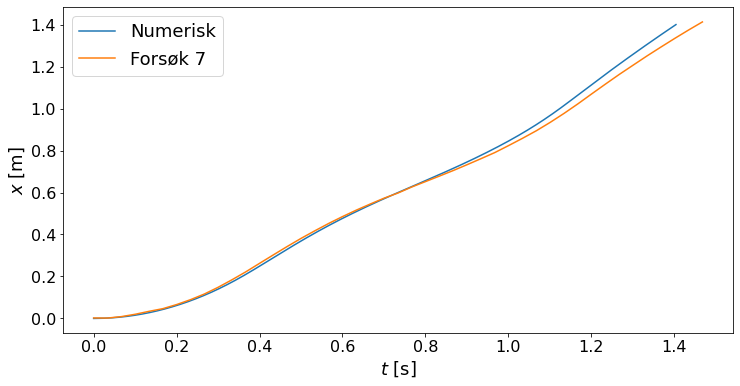

In [151]:
plot_comparison(t, x, t_exp, x_exp, xlabel=r"$t$ [s]", ylabel=r"$x$ [m]")

## Hastighet - $v(x)$  - plot


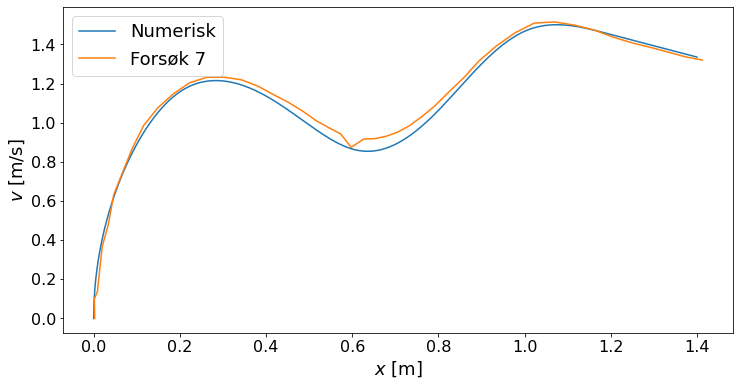

In [153]:
plot_comparison(x, v_num, x_exp, v_exp, ylabel=r'$v$ [m/s]')

# Krefter - sammenligning - plot

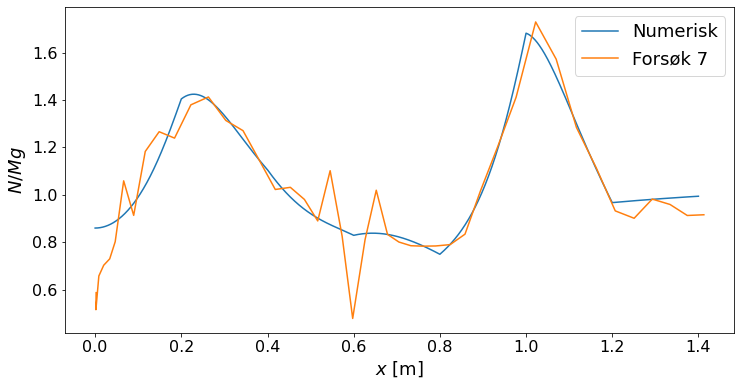

In [154]:
# N/mg
plot_comparison(x, N_mg, x_exp, N_mg_experimental, ylabel=r'$N/Mg$')

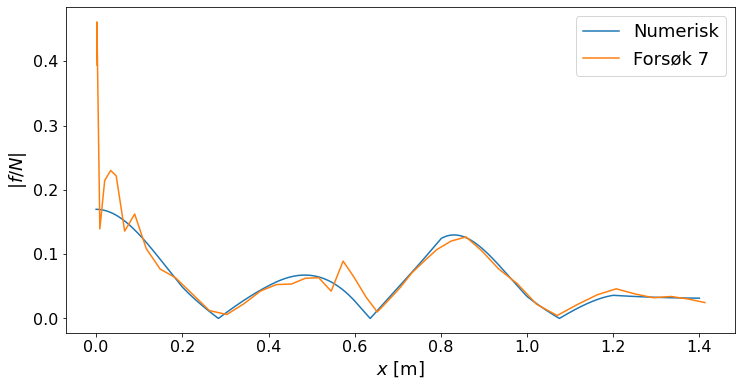

In [156]:
plot_comparison(x, f_N, x_exp, f_N_experimental, ylabel=r'$|f/N|$')

## Krumming og grader

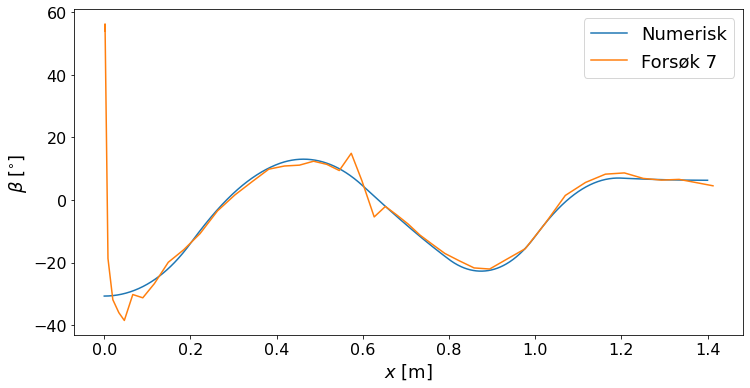

In [158]:
plot_comparison(x, beta_deg, x_exp, beta_exp, ylabel=r'$\beta \; [^{\circ}]$')

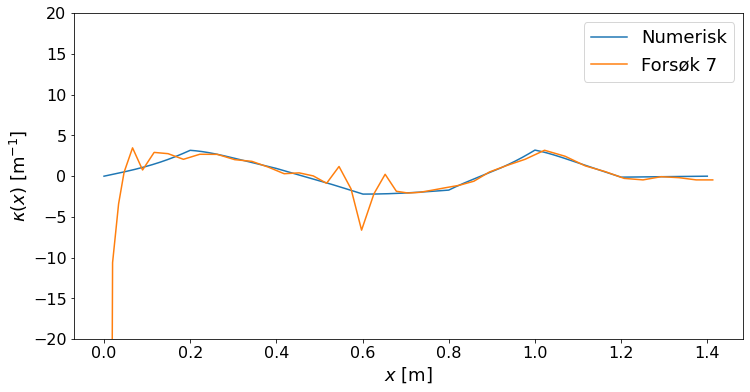

In [162]:
plt.plot(x, k_num, label="Numerisk")
plt.plot(x_exp, k_exp, label="Forsøk 7")
plt.xlabel(r'$x$ [m]', fontsize=18)
plt.ylabel(r'$\kappa(x)$ [m$^{-1}$]', fontsize=18)
plt.ylim(-20,20)
plt.legend(fontsize=18)
#plt.savefig("k_x_plot.pdf", bbox_inches="tight")
plt.show()

# Slutthastigheter


In [143]:
v_f = []
for i in range(len(x_lists)):
    t_i, x_i, y_i = list(t_lists[i][-2:]), list(x_lists[i][-2:]), list(y_lists[i][-2:])
    v_avg = ((y_i[1]-y_i[0]) + (x_i[1] - x_i[0])) / (t_i[1] - t_i[0])
    v_f.append(v_avg)
v_f = np.array(v_f)
print(v_f)

[1.36499161 1.33109413 1.16340269 1.29627518 1.37749553 1.33588145
 1.27856107 1.24552607 1.29326903 1.29187759]


In [144]:
# Calculate Mean and median of final speeds
v_f_avg, v_f_median = np.mean(v_f), np.median(v_f)
v_f_std = np.std(v_f, ddof=1)
v_f_SE = stats.sem(v_f)
print("Mean:\t\t", v_f_avg)
print("STD:\t\t", v_f_std)
print("Standard error:",v_f_SE)
print("Numeric v_f:", v(y[-1], y[0]))

Mean:		 1.2978374360119667
STD:		 0.062046612242160376
Standard error: 0.019620861578251363
Numeric v_f: 1.3355248722324227


### Energibevaring

In [145]:
c=2/5
E_i_num = np.round(M*g*y[0], 8)
E_f_num = np.round(M*g*y[-1] + 0.5 * M * v(y, y[0])[-1]**2 * (c + 1), 8)
delta_E_num = E_f_num - E_i_num

E_i_exp = M*g*np.array([y_val[0] for y_val in y_lists])
# Nestsiste frame er festepunktet
E_f_exp = M*g*np.array([y_val[-2] for y_val in y_lists]) + \
            0.5 * M * v_f**2 * (c + 1) 

avg_E_i_exp, avg_E_f_exp = np.round(np.mean(E_i_exp), 6), np.round(np.mean(E_f_exp), 6)
print(E_i_exp)
print(f"{avg_E_i_exp=}, {avg_E_f_exp=}")
print(f"{E_i_num=} {E_f_num=}")
print("SSE avg_E_i:\t", stats.sem(E_i_exp))
print("SSE avg_E_f:\t", stats.sem(E_f_exp))
print("STD avg_E_i:\t", np.std(E_i_exp, ddof=1))
print("STD avg_E_f:\t", np.std(E_f_exp, ddof=1))


[0.12830951 0.12864117 0.12799097 0.12854698 0.12779517 0.1283449
 0.12824557 0.12830884 0.12839685 0.12790078]
avg_E_i_exp=0.128248, avg_E_f_exp=0.126568
E_i_num=0.12059956 E_f_num=0.12059956
SSE avg_E_i:	 8.65825862200207e-05
SSE avg_E_f:	 0.0009852431101836862
STD avg_E_i:	 0.00027379817816317406
STD avg_E_f:	 0.003115612277168684
